In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
from tensorflow import keras
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
from scipy.fftpack import next_fast_len
from scipy.signal import spectrogram

In [ ]:
def get_all_filenames(file_dir):
    all_files = [file for file in os.listdir(file_dir)]
    return all_files

def __get_norm(norm):
    if norm == 0 or norm is None:
        return None, None
    else:
        try:
            norm1, norm2 = norm
        except TypeError:
            norm1 = norm2 = norm
        return norm1, norm2

def __freq_ind(freq, f0):
    try:
        return [np.argmin(np.abs(freq - f)) for f in f0]
    except TypeError:
        return np.argmin(np.abs(freq - f0))

def __product_other_freqs(spec, indices, synthetic=(), t=None):
    p1 = np.prod([amplitude * np.exp(2j * np.pi * freq * t + phase)
                  for (freq, amplitude, phase) in synthetic], axis=0)
    p2 = np.prod(spec[:, indices[len(synthetic):]], axis=1)
    return p1 * p2

In [ ]:
def _polycoherence_0d(data, fs, *freqs, norm=2, synthetic=(), **kwargs): #python polycoherence wrap function

    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    ind = __freq_ind(freq, freqs)
    sum_ind = __freq_ind(freq, np.sum(freqs))
    spec = np.transpose(spec, [1, 0])
    p1 = __product_other_freqs(spec, ind, synthetic, t)
    p2 = np.conjugate(spec[:, sum_ind])
    coh = np.mean(p1 * p2, axis=0)
    if norm is not None:
        coh = np.abs(coh)
        coh **= 2
        temp2 = np.mean(np.abs(p1) ** norm1 * np.abs(p2) ** norm2, axis=0)
        coh /= temp2
        coh **= 0.5
    return coh


def _polycoherence_1d(data, fs, *freqs, norm=2, synthetic=(), **kwargs):

    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    spec = np.transpose(spec, [1, 0])
    ind2 = __freq_ind(freq, freqs)
    ind1 = np.arange(len(freq) - sum(ind2))
    sumind = ind1 + sum(ind2)
    otemp = __product_other_freqs(spec, ind2, synthetic, t)[:, None]
    temp = spec[:, ind1] * otemp
    temp2 = np.mean(np.abs(temp) ** 2, axis=0)
    temp *= np.conjugate(spec[:, sumind])
    coh = np.mean(temp, axis=0)
    if norm is not None:
        coh = np.abs(coh)
        coh **= 2
        temp2 *= np.mean(np.abs(spec[:, sumind]) ** 2, axis=0)
        coh /= temp2
        coh **= 0.5
    return freq[ind1], coh


def _polycoherence_1d_sum(data, fs, f0, *ofreqs, norm=2,
                          synthetic=(), **kwargs):

    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    spec = np.transpose(spec, [1, 0])
    ind3 = __freq_ind(freq, ofreqs)
    otemp = __product_other_freqs(spec, ind3, synthetic, t)[:, None]
    sumind = __freq_ind(freq, f0)
    ind1 = np.arange(np.searchsorted(freq, f0 - np.sum(ofreqs)))
    ind2 = sumind - ind1 - sum(ind3)
    temp = spec[:, ind1] * spec[:, ind2] * otemp
    if norm is not None:
        temp2 = np.mean(np.abs(temp) ** 2, axis=0)
    temp *= np.conjugate(spec[:, sumind, None])
    coh = np.mean(temp, axis=0)
    if norm is not None:
        coh = np.abs(coh)
        coh **= 2
        temp2 *= np.mean(np.abs(spec[:, sumind]) ** 2, axis=0)
        coh /= temp2
        coh **= 0.5
    return freq[ind1], coh


def _polycoherence_2d(data, fs, *ofreqs, norm=2, flim1=None, flim2=None,
                      synthetic=(), **kwargs):

    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    spec = np.require(spec, 'complex64')
    spec = np.transpose(spec, [1, 0])
    if flim1 is None:
        flim1 = (0, (np.max(freq) - np.sum(ofreqs)) / 2)
    if flim2 is None:
        flim2 = (0, (np.max(freq) - np.sum(ofreqs)) / 2)
    ind1 = np.arange(*np.searchsorted(freq, flim1))
    ind2 = np.arange(*np.searchsorted(freq, flim2))
    ind3 = __freq_ind(freq, ofreqs)
    otemp = __product_other_freqs(spec, ind3, synthetic, t)[:, None, None]
    sumind = ind1[:, None] + ind2[None, :] + sum(ind3)
    temp = spec[:, ind1, None] * spec[:, None, ind2] * otemp
    if norm is not None:
        temp2 = np.mean(np.abs(temp) ** norm1, axis=0)
    temp *= np.conjugate(spec[:, sumind])
    coh = np.mean(temp, axis=0)
    del temp
    if norm is not None:
        coh = np.abs(coh, out=coh)
        coh **= 2
        temp2 *= np.mean(np.abs(spec[:, sumind]) ** norm2, axis=0)
        coh /= temp2
        coh **= 0.5
    return freq[ind1], freq[ind2], coh

    
def polycoherence(data, *args, dim=2, **kwargs):

    N = len(data)
    kwargs.setdefault('nperseg', N // 20)
    kwargs.setdefault('nfft', next_fast_len(N // 10))
    if dim == 0:
        f = _polycoherence_0d
    elif dim == 1:
        f = _polycoherence_1d
    elif dim == 'sum':
        f = _polycoherence_1d_sum
    elif dim == 2:
        f = _polycoherence_2d
    else:
        raise
    return f(data, *args, **kwargs)

In [ ]:
def featureextract(file_folder, class_list, data_num=2000): #feature extract
    dataset = np.zeros((1,256,256,1))
    for class_nam in class_list:
        path = os.path.join(file_folder, class_nam)
        all_files = get_all_filenames(path)
        index = 0
        for name in all_files[:data_num]:
            file_path = os.path.join(path, name)
            sig, sr = librosa.load(file_path, sr=1000)
            freq1, freq2, bi_spectrum = polycoherence(sig,nfft=1024, fs = 1000, norm=None,noverlap = 100, nperseg=256)
            bi_spectrum = np.array(abs(bi_spectrum))
            bi_spectrum = bi_spectrum.reshape((256, 256, 1))
            bi_spectrum = 255 * (bi_spectrum - np.min(bi_spectrum)) / (np.max(bi_spectrum) - np.min(bi_spectrum))
            dataset = np.vstack((dataset, np.array([bi_spectrum])))
            index+=1
    dataset = np.delete(dataset, 0, 0)
    return dataset

In [ ]:
def build_model(): #neural network Construct
    
    inputdata = keras.Input(shape=(256, 256, 1))

    final = keras.layers.Conv2D(32, (3, 3), padding="same",activation='relu')(inputdata)
    final = keras.layers.BatchNormalization()(final)
    final = keras.layers.ReLU()(final)
    final = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(final)

    final = keras.layers.Conv2D(16, (3, 3), padding="same",activation='relu')(final)
    final = keras.layers.BatchNormalization()(final)
    final = keras.layers.ReLU()(final)
    final = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(final)

    final = keras.layers.Conv2D(8, (3, 3), padding="same",activation='relu')(final)
    final = keras.layers.BatchNormalization()(final)
    final = keras.layers.ReLU()(final)
    final = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(final)

    final = keras.layers.Conv2D(16, (3, 3), padding="same",activation='relu')(final)
    final = keras.layers.BatchNormalization()(final)
    final = keras.layers.ReLU()(final)

    final = keras.layers.Flatten()(final)
    final = keras.layers.Dense(4)(final)
    final = keras.layers.Softmax()(final)

    model = keras.Model(inputs=inputdata, outputs=final)
    optimizer = keras.optimizers.Adam(
        lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
def accuracy(label,prediction):
    num=0
    N = len(label)
    for i in range(len(label)):
        pred = np.argmax(prediction[i])
        if label[i]==pred:
            num+=1
    return num/N


def Shuffle(data, label):
    state = np.random.get_state()
    np.random.shuffle(data)
    np.random.set_state(state)
    np.random.shuffle(label)
    return data,label


def generate(num=200):
    label = []
    for j in range(4):
        for i in range(num):
            label.append(j)
    return np.array(label)


if __name__ == '__main__':
    np.random.seed(0)
    filename = 'dataset'
    label_name = ['AS', 'MS', 'MR', 'MVP']
    dataset = featureextract(filename, label_name)
    label = generate()
    image,label = Shuffle(dataset,label)
    train_data = image[:600,:,:]
    train_label = label[:600]
    test_data = image[600:,:,:]
    test_label = label[600:]
    model = build_model()
    history = model.fit(train_data, train_label,
                        epochs=10,
                        batch_size=16,
                        verbose=1)
    model.save('modelsave.h5')
    predictions = model.predict(test_data)
    np.save('result/pred',predictions)
    np.save('result/label',test_label)
    acc = accuracy(test_label,predictions)
    print('Final Accuracy: ',acc)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      4624  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
Epoch 1/10
38/38 [==============================] - 12s 34ms/step - loss: 1.0262 - accuracy: 0.7417
Epoch 2/10
38/38 [==============================] - 1s 28ms/step - loss: 0.1310 - accuracy: 0.9417
Epoch 3/10
38/38 [==============================] - 1s 29ms/step - loss: 0.0567 - accuracy: 0.9833
Epoch 4/10
38/38 [==============================] - 1s 28ms/step - loss: 0.0226 - accuracy: 0.9933
Epoch 5/10
38/38 [==============================] - 1s 28ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 1s 28ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 1s 28ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 8/10
38/38 [==============================] - 1s 28ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 9/10
38/38 [==============================] - 1s 28ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 10/10
38/38 [==============================] - 1s 29ms/step - loss: 0.0017 - accuracy: 1.0000
Fin

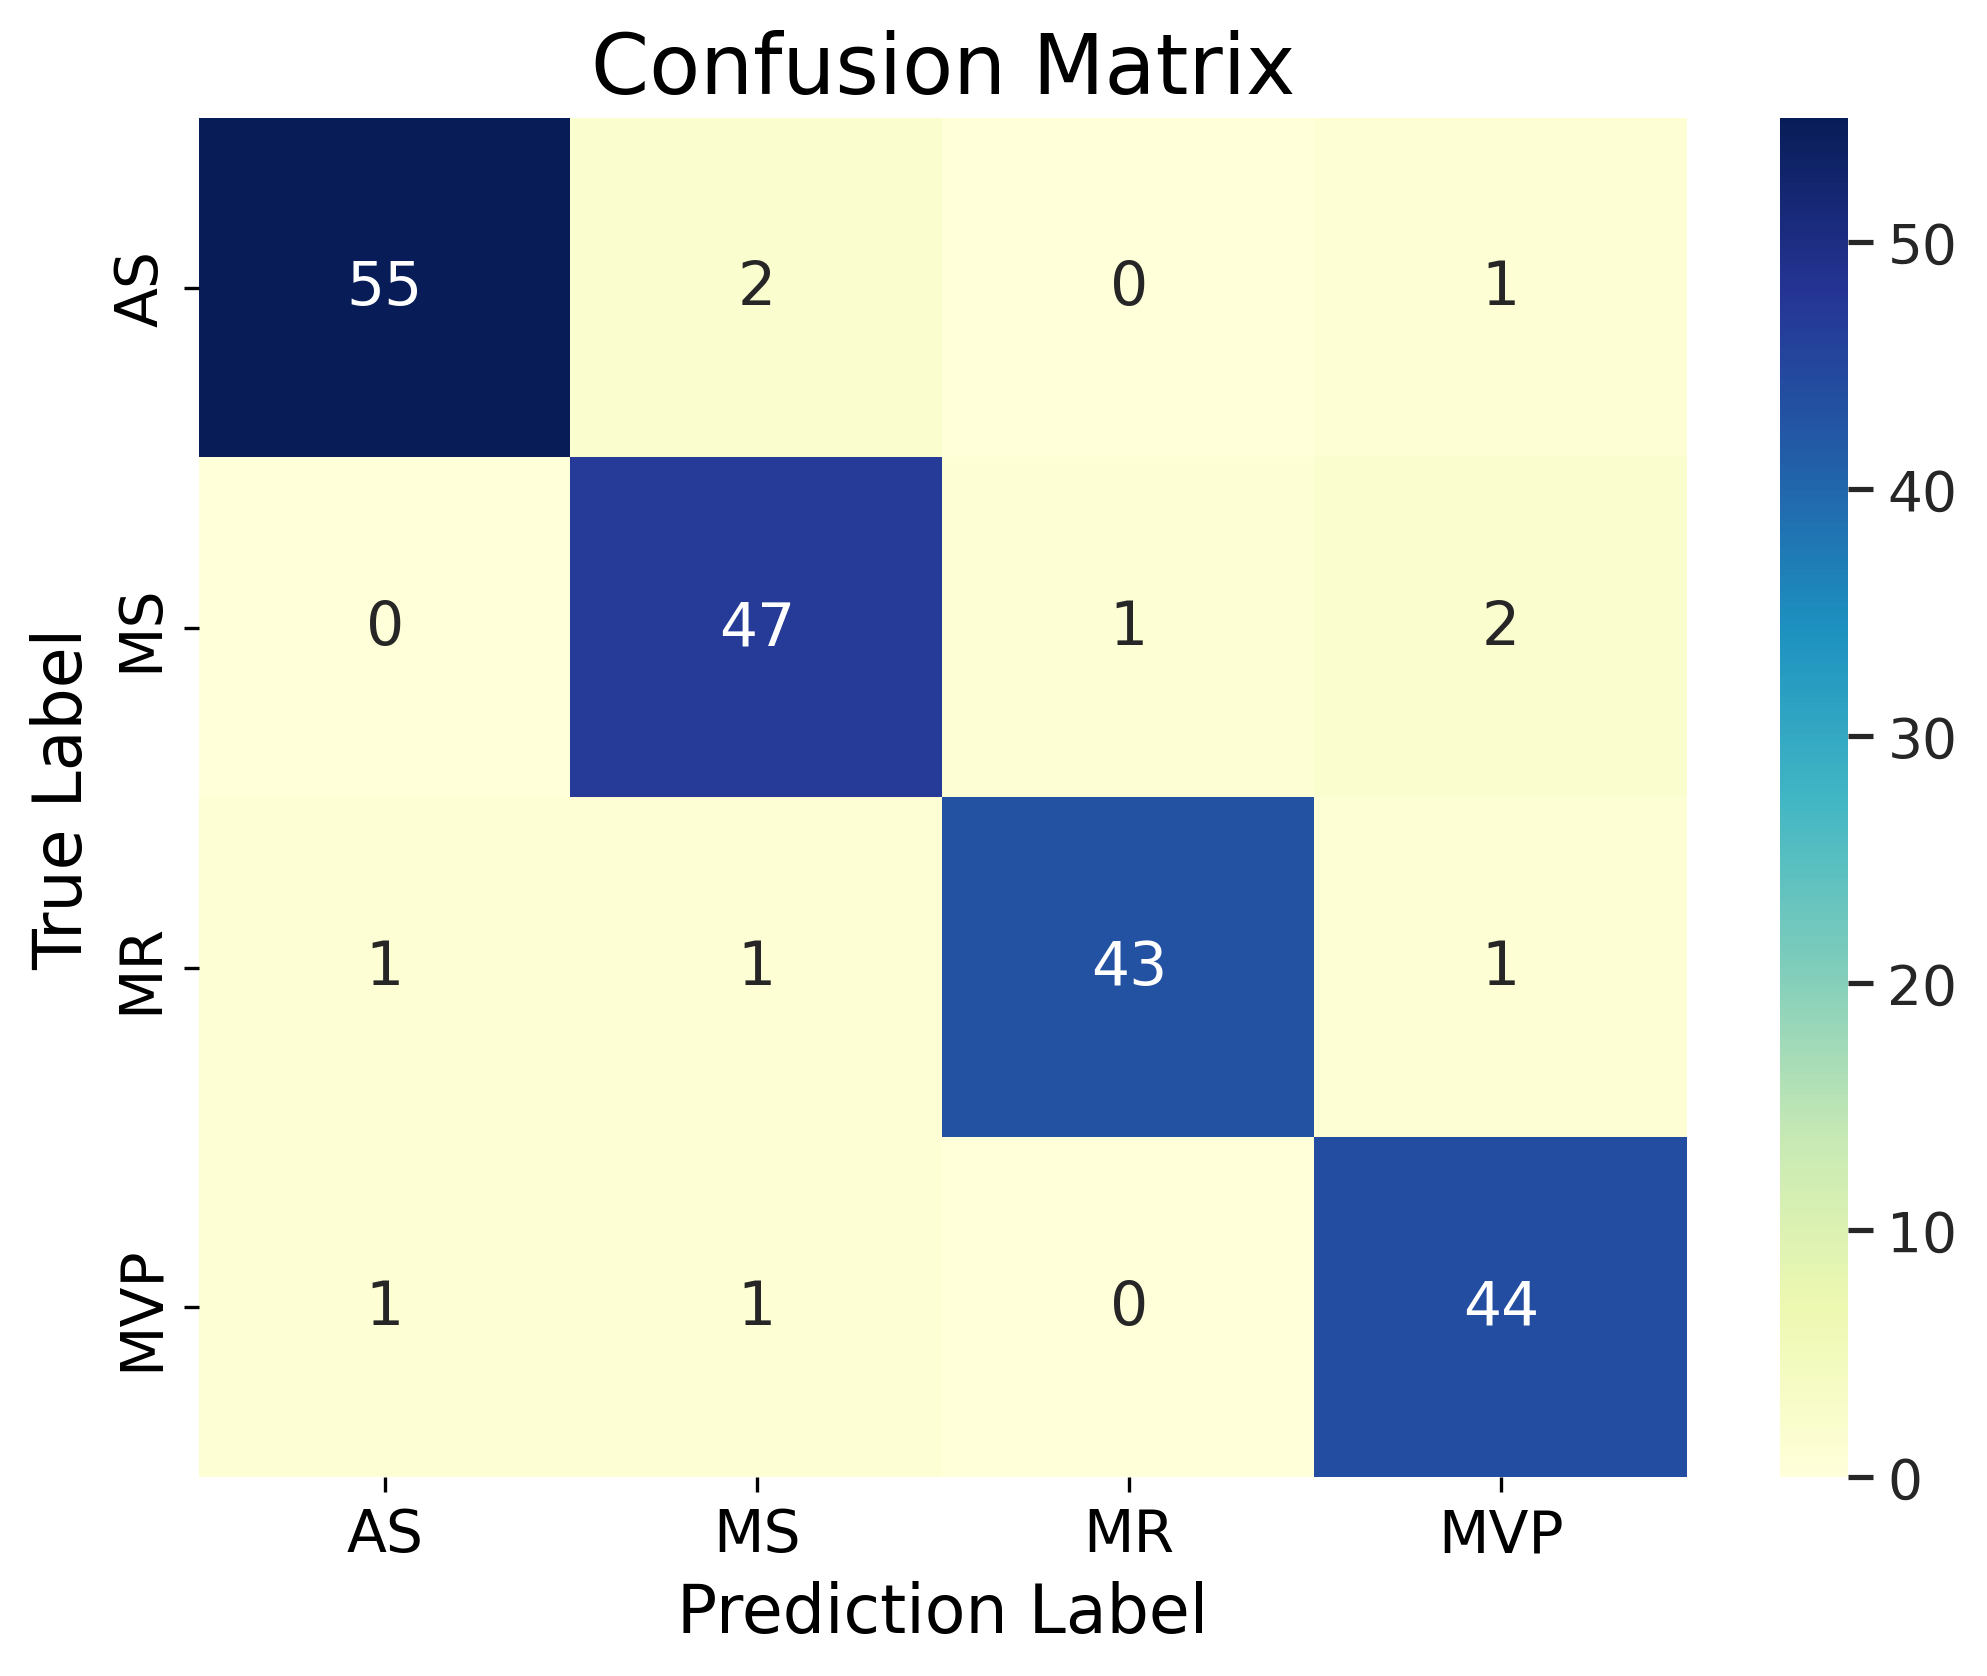

In [ ]:
def get_result(prediction):
    out = []
    for i in range(len(prediction)):
        out.append(np.argmax(prediction[i]))
    return np.array(out)


savelabel = np.load('result/label.npy')
savepred = np.load('result/pred.npy')
prediction = get_result(savepred)
fig = plt.figure(figsize=(8,6),dpi=300)
img = fig.add_subplot(111)
confmatrix = confusion_matrix(savelabel, prediction)
sns.set(font_scale=1.2)
sns.heatmap(confmatrix,
            annot=True,
            xticklabels=['AS', 'MS', 'MR', 'MVP'],
            yticklabels=['AS', 'MS', 'MR', 'MVP'],
            cmap = plt.cm.YlGnBu
            )
img.set_title('Confusion Matrix',fontsize = 20)
img.set_xlabel('Prediction Label',fontsize = 16)
img.set_ylabel('True Label',fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()